In [1]:
#tutto ciò l'ho fatto semza bilanciare gli alberi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC

In [ ]:
#mannaggia alla pepett hai usato gini e dovevi usare l'entropia ahhhhhhhhhhhhhhh

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [3]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

In [4]:
y.value_counts()

3    53
4    27
1    12
5     6
2     5
Name: COD ISTO, dtype: int64

In [5]:
seed = 42

In [6]:
#separo test set e training set
#eseguo questa unica separazione iniziale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   random_state=seed, shuffle = True,
                                                   stratify = y)

## maligni contro benigni

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

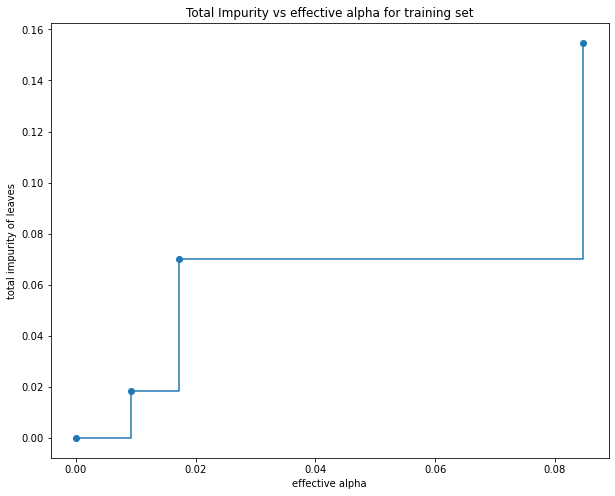

In [7]:


#creazione delle labels
y_train_MvsB= [1 if x in (1,2) else 0 for x in y_train]
y_test_MvsB = [1 if x in (1,2) else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_MvsB)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)

#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [8]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_MvsB)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.12836803489986115


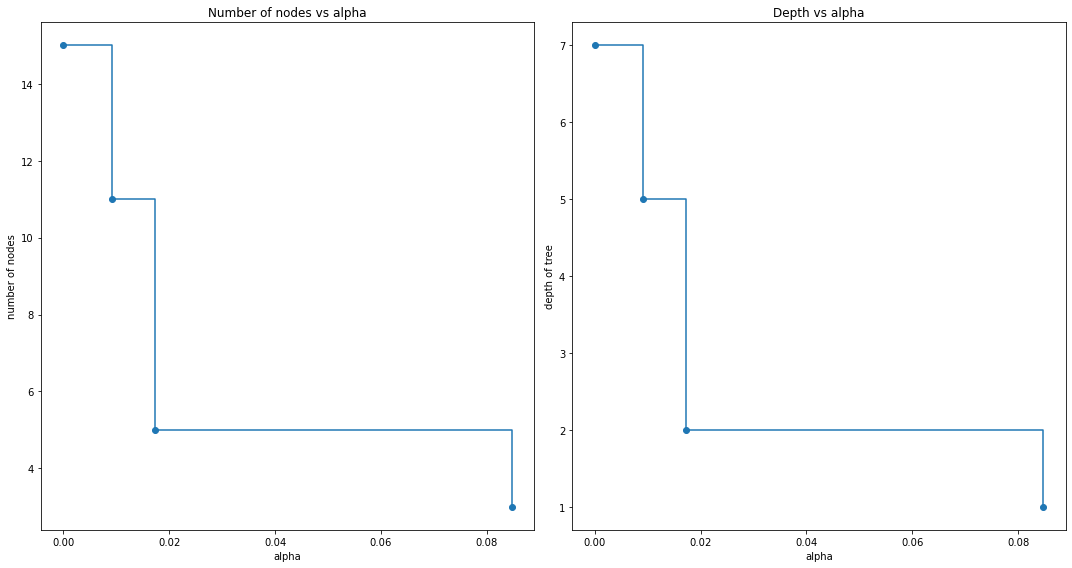

In [9]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

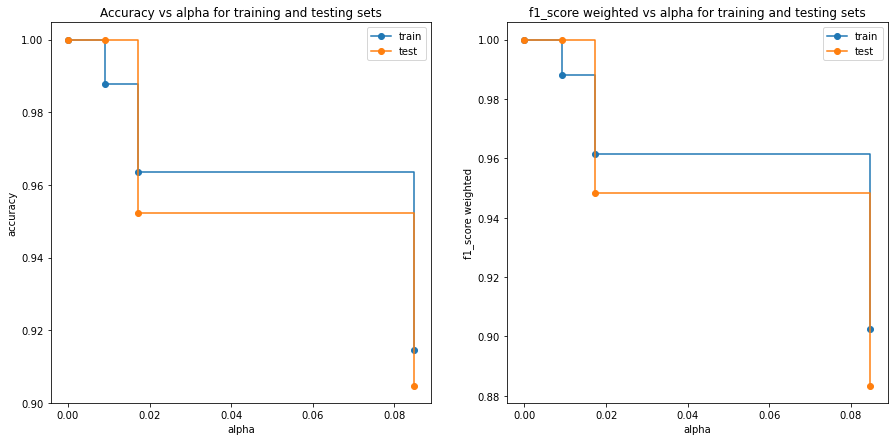

In [10]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_MvsB) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_MvsB) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_MvsB, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_MvsB, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(358.7142857142857, 747.4499999999999, 'Segni macro malignità <= 0.5\ngini = 0.283\nsamples = 82\nvalue = [68, 14]\nclass = 0'),
 Text(239.14285714285714, 611.55, 'ADC <= 0.6\ngini = 0.169\nsamples = 75\nvalue = [68, 7]\nclass = 0'),
 Text(119.57142857142857, 475.65, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = 1'),
 Text(358.7142857142857, 475.65, 'TIC type_C <= 0.5\ngini = 0.081\nsamples = 71\nvalue = [68, 3]\nclass = 0'),
 Text(239.14285714285714, 339.74999999999994, 'gini = 0.0\nsamples = 54\nvalue = [54, 0]\nclass = 0'),
 Text(478.2857142857143, 339.74999999999994, 'T2 <= 0.5\ngini = 0.291\nsamples = 17\nvalue = [14, 3]\nclass = 0'),
 Text(358.7142857142857, 203.8499999999999, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = 0'),
 Text(597.8571428571429, 203.8499999999999, 'ADC <= 1.275\ngini = 0.469\nsamples = 8\nvalue = [5, 3]\nclass = 0'),
 Text(478.2857142857143, 67.94999999999993, 'gini = 0.375\nsamples = 4\nvalue = [1, 3]\nclass = 1'),
 Text(717.4285714285714, 67.

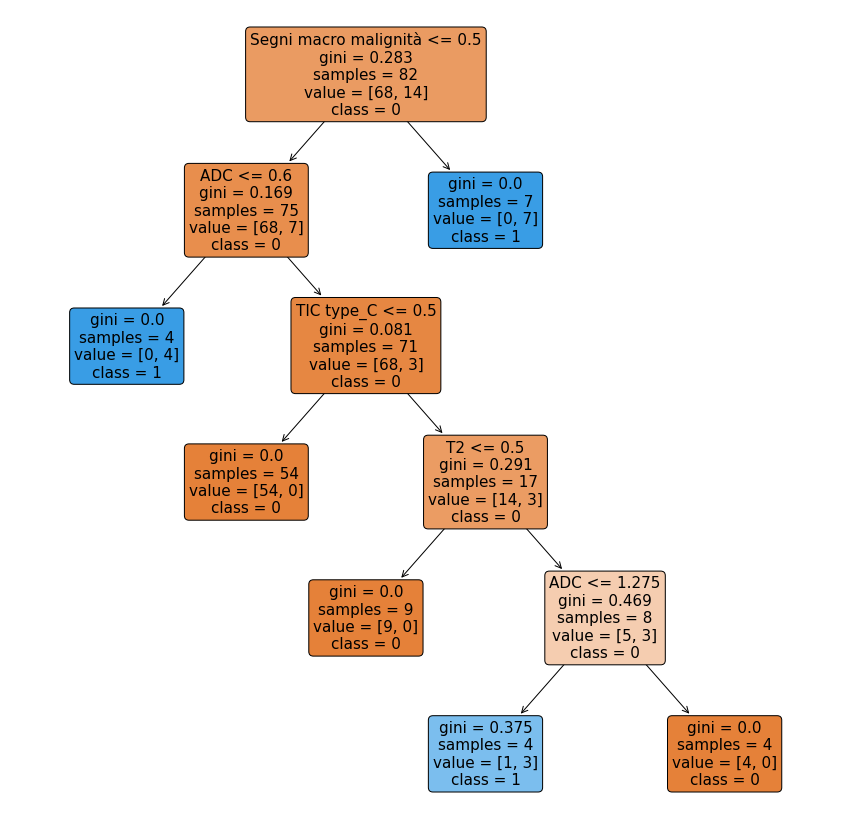

In [11]:
best_clf = clfs[1]
clf_MvsB = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [12]:
print(classification_report(y_test_MvsB, clf_MvsB.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         3

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [13]:
#molto rincuorante

## 1 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

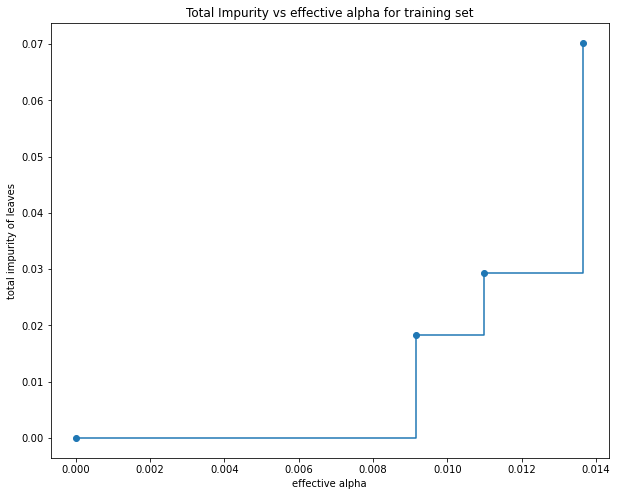

In [14]:
#creazione delle labels
y_train_1vsAll= [1 if x == 1 else 0 for x in y_train]
y_test_1vsAll = [1 if x == 1 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_1vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [15]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_1vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.1439143367043427


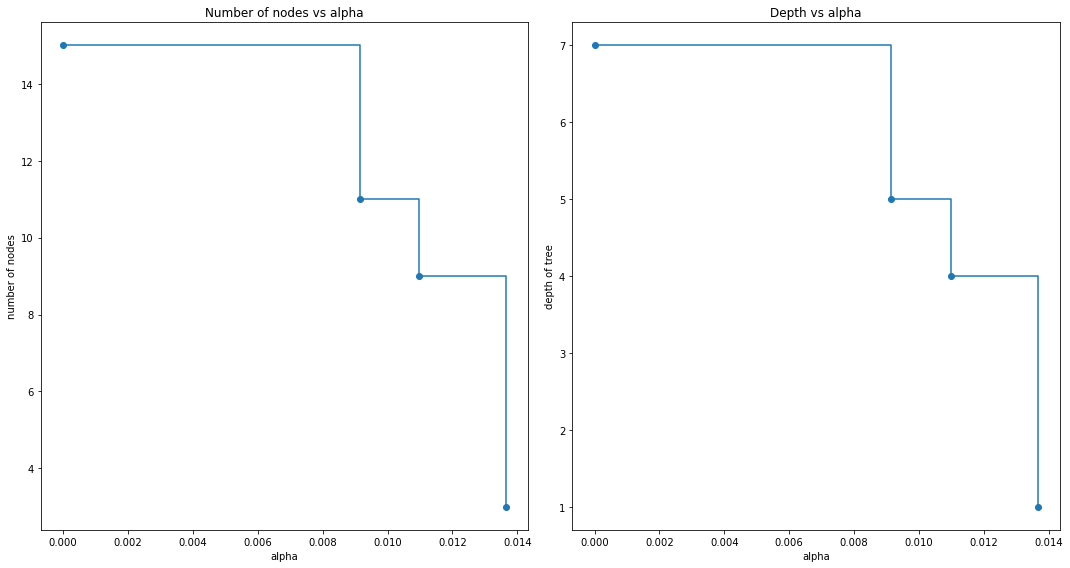

In [16]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

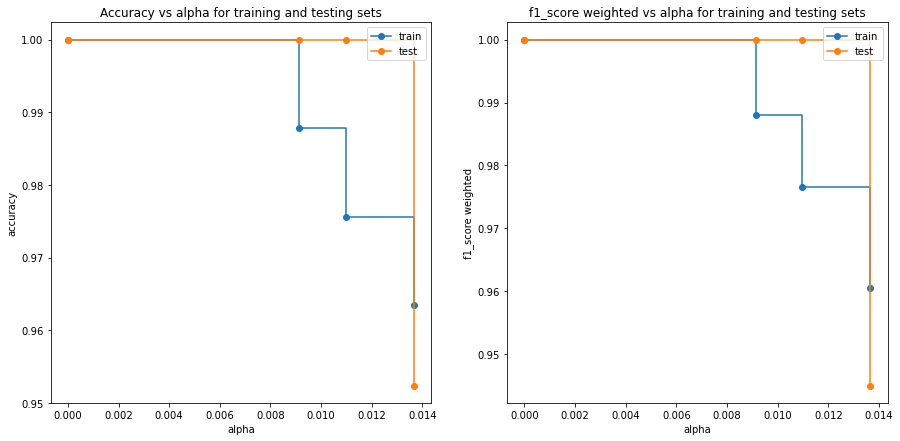

In [17]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_1vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_1vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_1vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_1vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(418.5, 733.86, 'Segni macro malignità <= 0.5\ngini = 0.214\nsamples = 82\nvalue = [72, 10]\nclass = 0'),
 Text(279.0, 570.78, 'TIC type_C <= 0.5\ngini = 0.077\nsamples = 75\nvalue = [72, 3]\nclass = 0'),
 Text(139.5, 407.70000000000005, 'gini = 0.0\nsamples = 56\nvalue = [56, 0]\nclass = 0'),
 Text(418.5, 407.70000000000005, 'T2 <= 0.5\ngini = 0.266\nsamples = 19\nvalue = [16, 3]\nclass = 0'),
 Text(279.0, 244.62, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = 0'),
 Text(558.0, 244.62, 'ADC <= 1.275\ngini = 0.444\nsamples = 9\nvalue = [6, 3]\nclass = 0'),
 Text(418.5, 81.54000000000008, 'gini = 0.48\nsamples = 5\nvalue = [2, 3]\nclass = 1'),
 Text(697.5, 81.54000000000008, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = 0'),
 Text(558.0, 570.78, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = 1')]

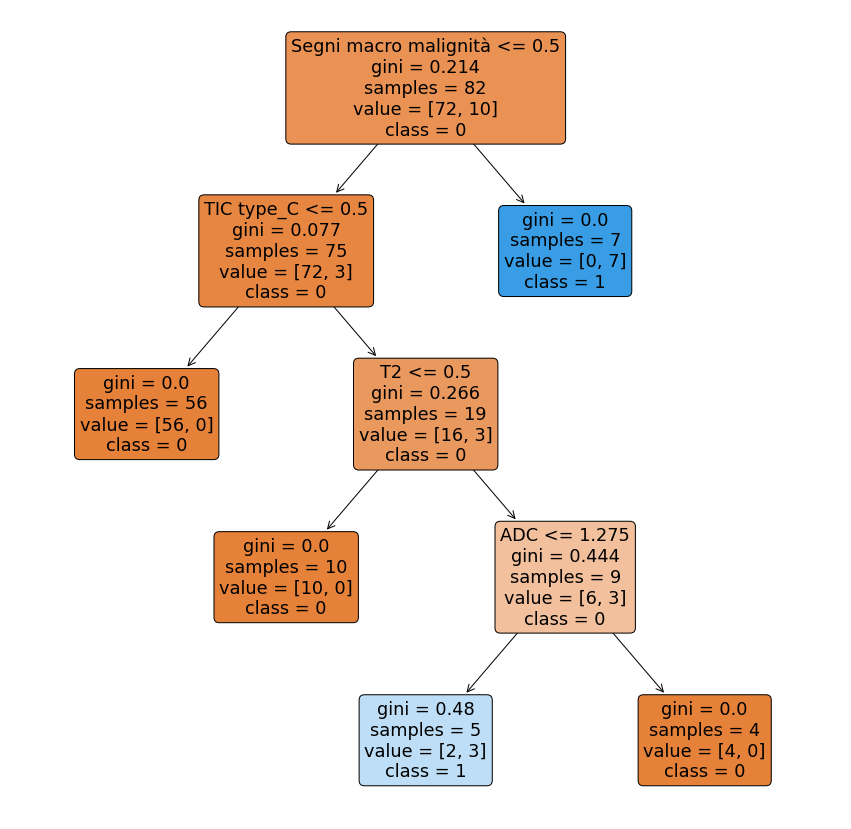

In [18]:
best_clf = clfs[2]
clf_1vsAll = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [19]:
print(classification_report(y_test_1vsAll, clf_1vsAll.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



## 2 vs All

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

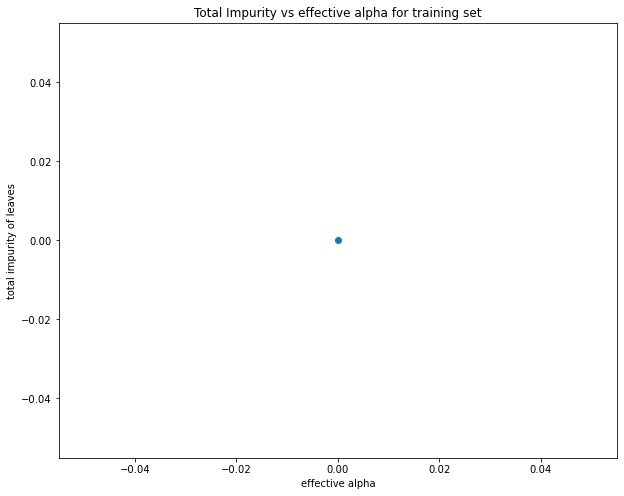

In [20]:
#creazione delle labels
y_train_2vsAll= [1 if x == 2 else 0 for x in y_train]
y_test_2vsAll = [1 if x == 2 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_2vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [21]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_2vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.09280190362879237


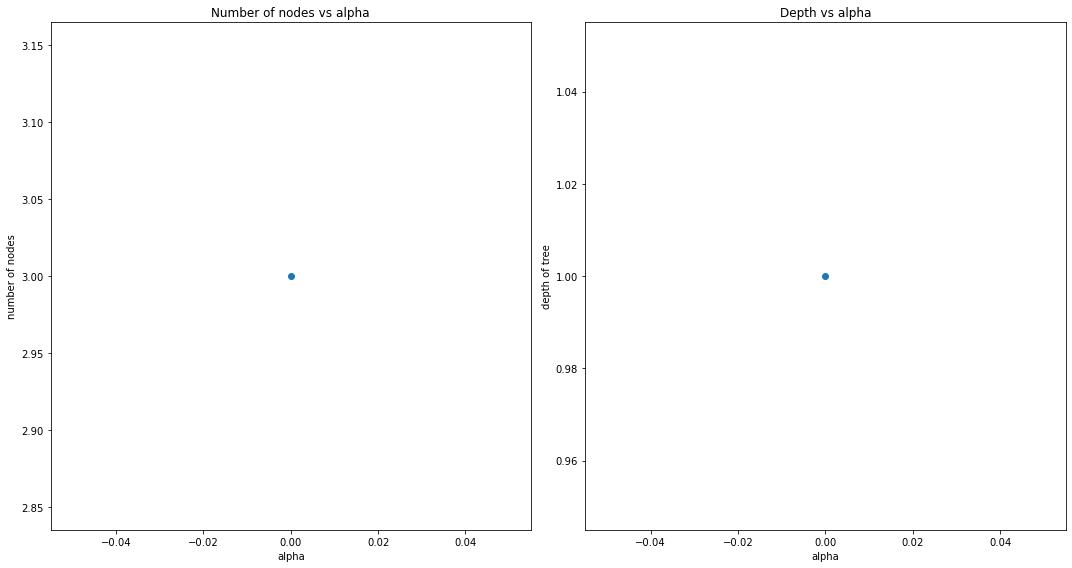

In [22]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

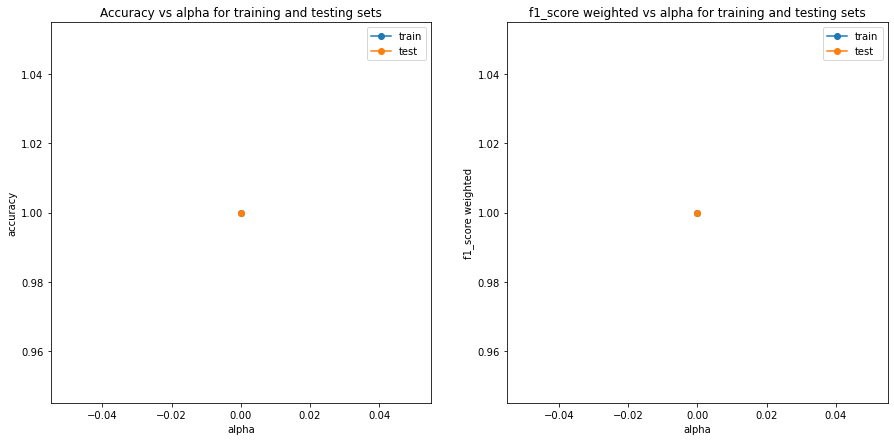

In [23]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_2vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_2vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_2vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_2vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(418.5, 611.55, 'ADC <= 0.6\ngini = 0.093\nsamples = 82\nvalue = [78, 4]\nclass = 0'),
 Text(209.25, 203.85000000000002, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = 1'),
 Text(627.75, 203.85000000000002, 'gini = 0.0\nsamples = 78\nvalue = [78, 0]\nclass = 0')]

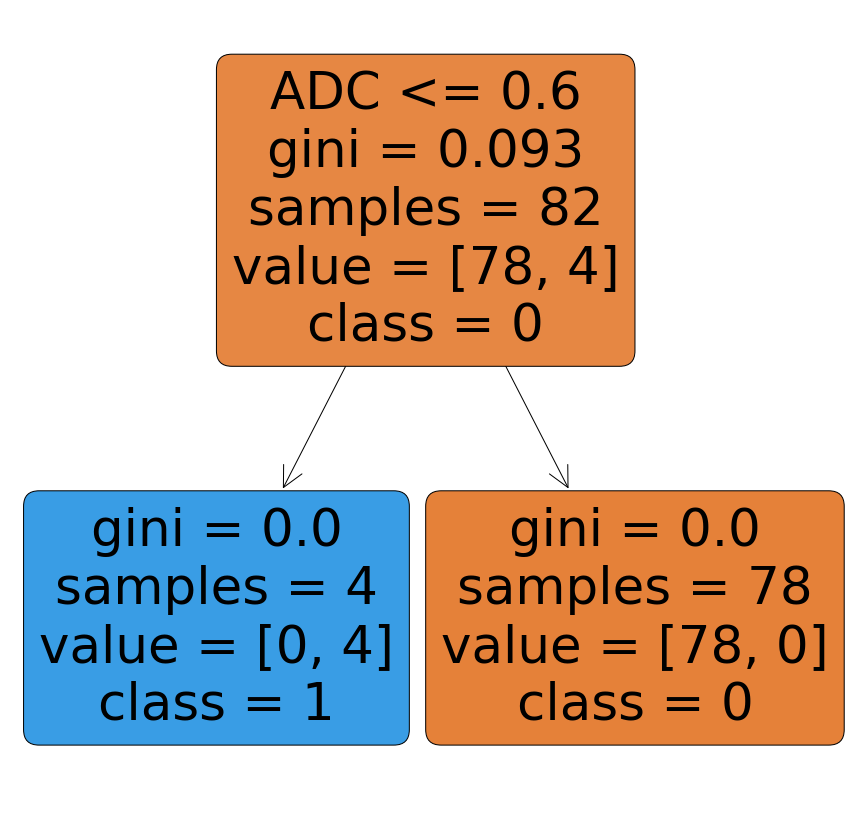

In [24]:
best_clf = clfs[0]
clf_2vsAll = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [25]:
print(classification_report(y_test_2vsAll, clf_2vsAll.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         1

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



## 3 vs All


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

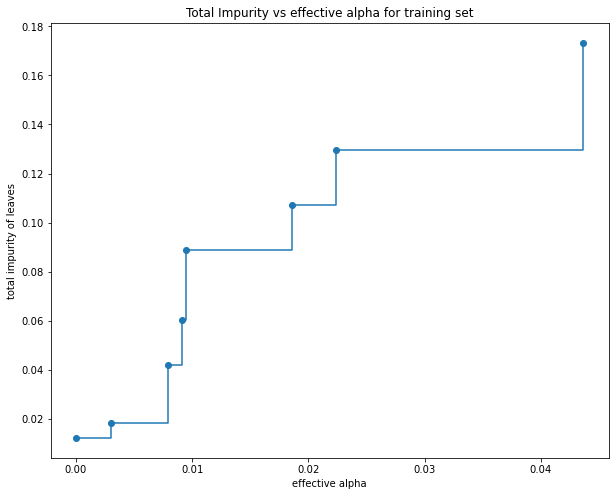

In [26]:
#complexity pruning per albero 3 vs all
### 3 vs All

#creazione delle labels
y_train_3vsAll = [1 if x == 3 else 0 for x in y_train]
y_test_3vsAll = [1 if x == 3 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_3vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [27]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_3vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3263786508490748


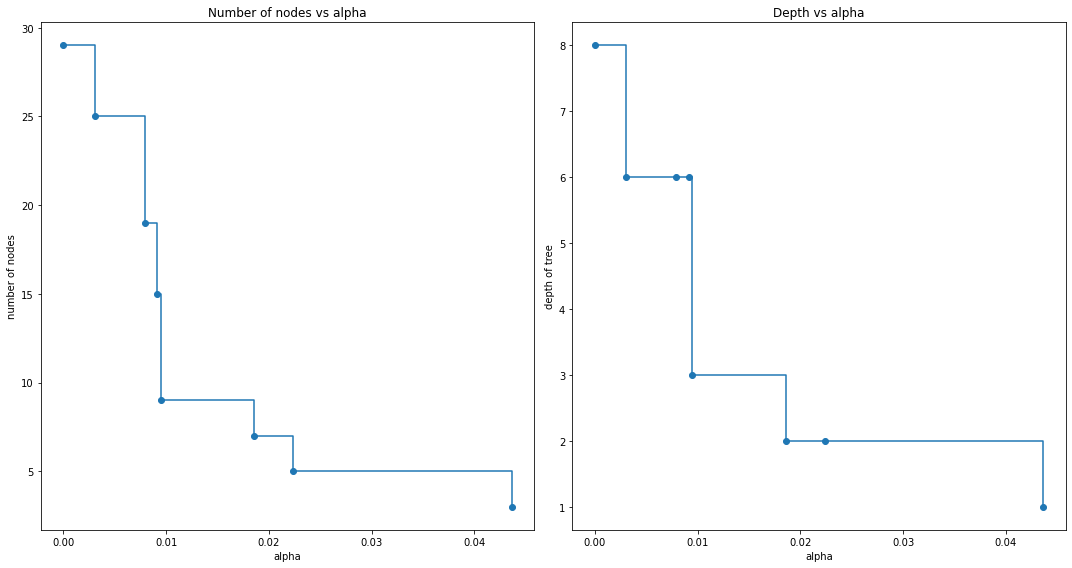

In [28]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

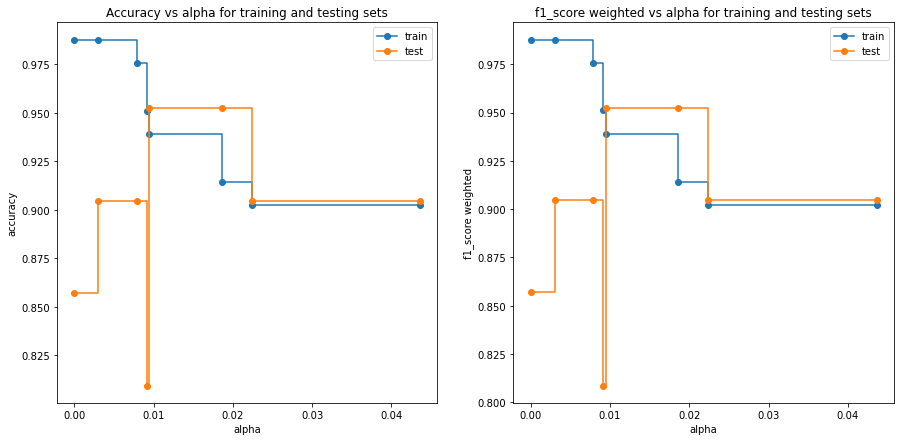

In [29]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_3vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_3vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_3vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_3vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()


plt.show()

[Text(418.5, 679.5, 'ADC <= 1.075\ngini = 0.5\nsamples = 82\nvalue = [40, 42]\nclass = 1'),
 Text(209.25, 407.69999999999993, 'TIC type_A <= 0.5\ngini = 0.105\nsamples = 36\nvalue = [34, 2]\nclass = 0'),
 Text(104.625, 135.89999999999998, 'gini = 0.056\nsamples = 35\nvalue = [34, 1]\nclass = 0'),
 Text(313.875, 135.89999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = 1'),
 Text(627.75, 407.69999999999993, 'TIC type_A <= 0.5\ngini = 0.227\nsamples = 46\nvalue = [6, 40]\nclass = 1'),
 Text(523.125, 135.89999999999998, 'gini = 0.49\nsamples = 14\nvalue = [6, 8]\nclass = 1'),
 Text(732.375, 135.89999999999998, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]\nclass = 1')]

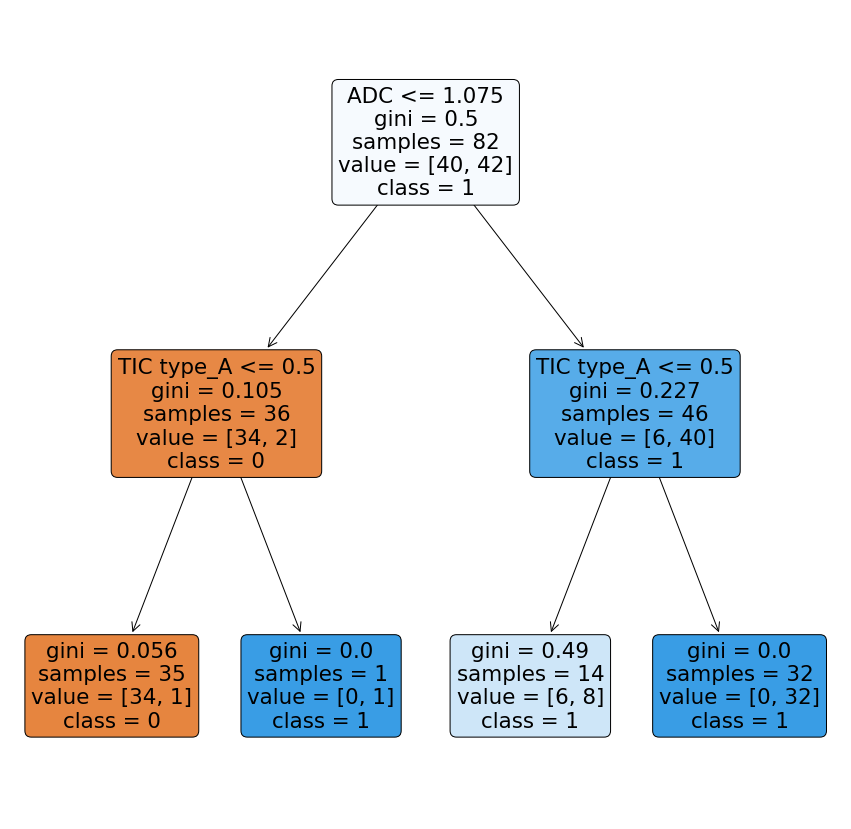

In [30]:
best_clf = clfs[5]
clf_3vsAll = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [31]:
print(classification_report(y_test_3vsAll, clf_3vsAll.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.92      1.00      0.96        11

    accuracy                           0.95        21
   macro avg       0.96      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



## 4 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

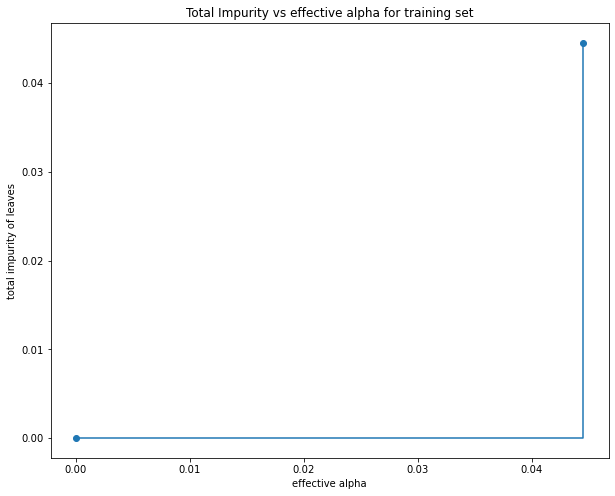

In [32]:
### 4 vs All

#creazione delle labels
y_train_4vsAll = [1 if x == 4 else 0 for x in y_train]
y_test_4vsAll = [1 if x == 4 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_4vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [33]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_4vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.33648449421927945


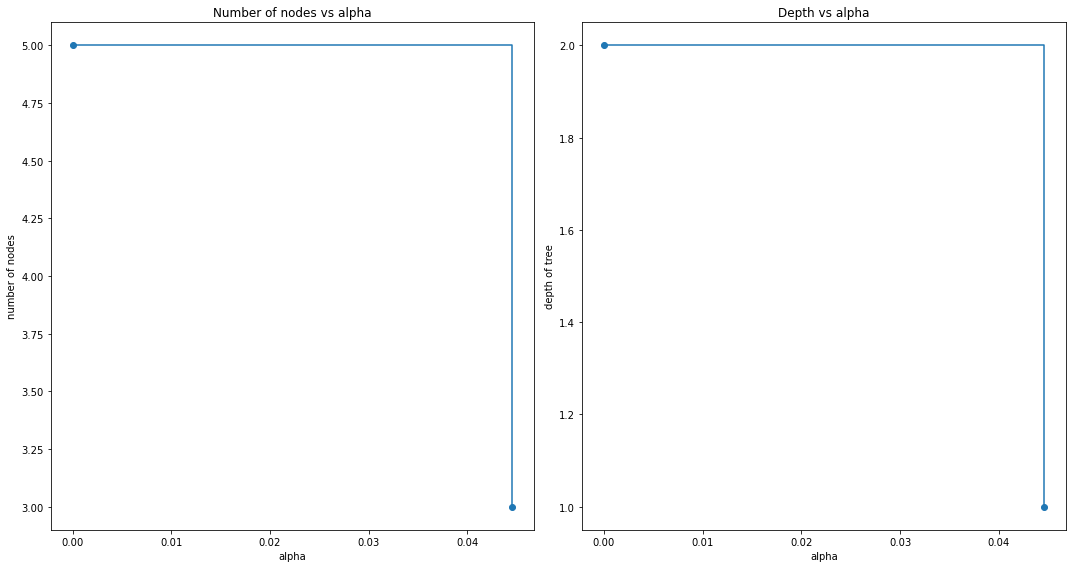

In [34]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

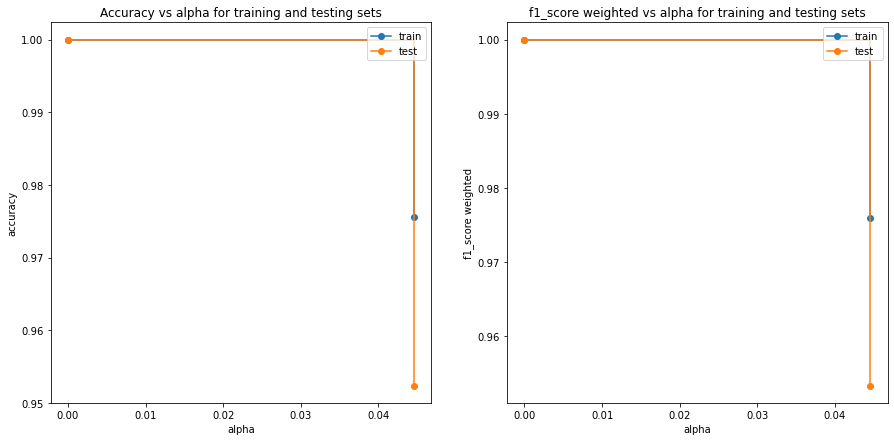

In [35]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_4vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_4vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_4vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_4vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()

[Text(334.8, 679.5, 'TIC type_B <= 0.5\ngini = 0.381\nsamples = 82\nvalue = [61, 21]\nclass = 0'),
 Text(167.4, 407.69999999999993, 'gini = 0.0\nsamples = 59\nvalue = [59, 0]\nclass = 0'),
 Text(502.20000000000005, 407.69999999999993, 'ADC <= 0.6\ngini = 0.159\nsamples = 23\nvalue = [2, 21]\nclass = 1'),
 Text(334.8, 135.89999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = 0'),
 Text(669.6, 135.89999999999998, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]\nclass = 1')]

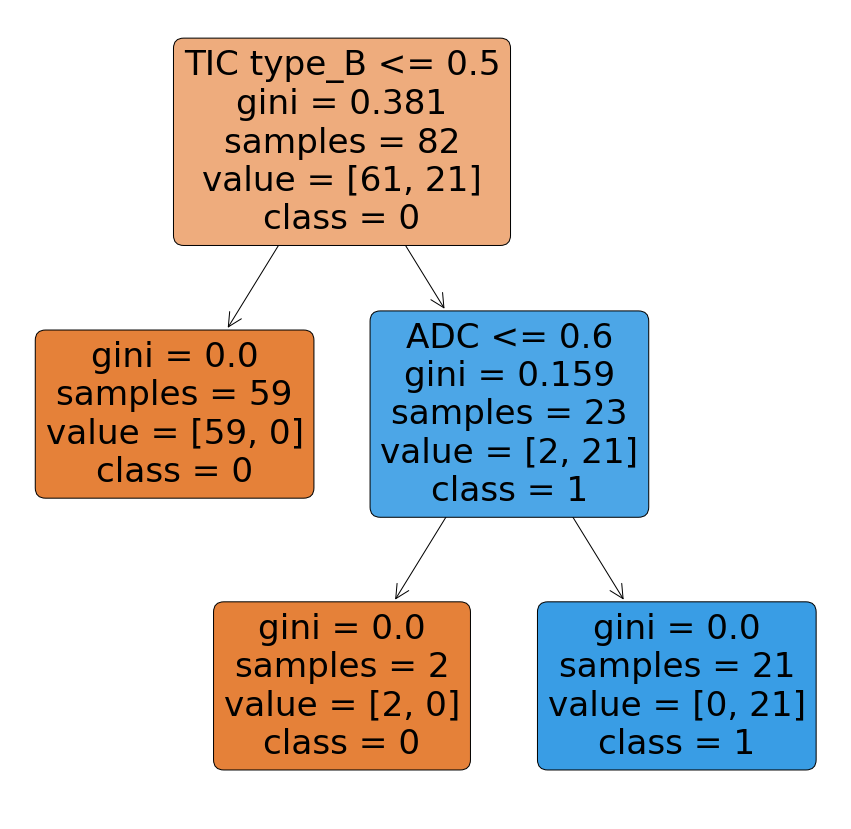

In [36]:
best_clf = clfs[0]
clf_4vsAll = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [37]:
print(classification_report(y_test_4vsAll, clf_4vsAll.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         6

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



# 5 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

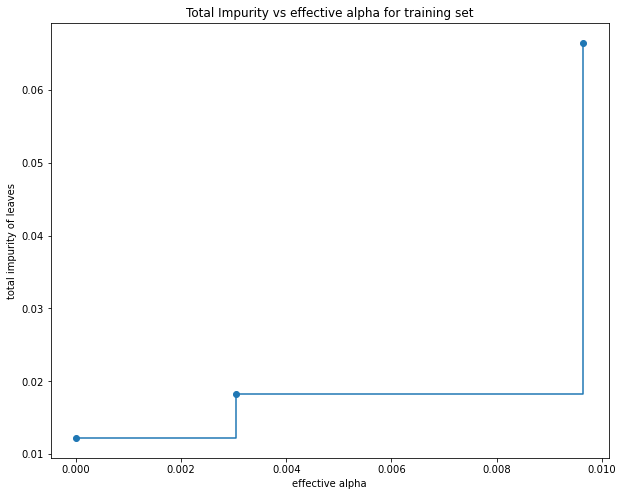

In [38]:
### 5 vs All

#creazione delle labels
y_train_5vsAll = [1 if x == 5 else 0 for x in y_train]
y_test_5vsAll = [1 if x == 5 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_5vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [39]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train_5vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.023998161267643703


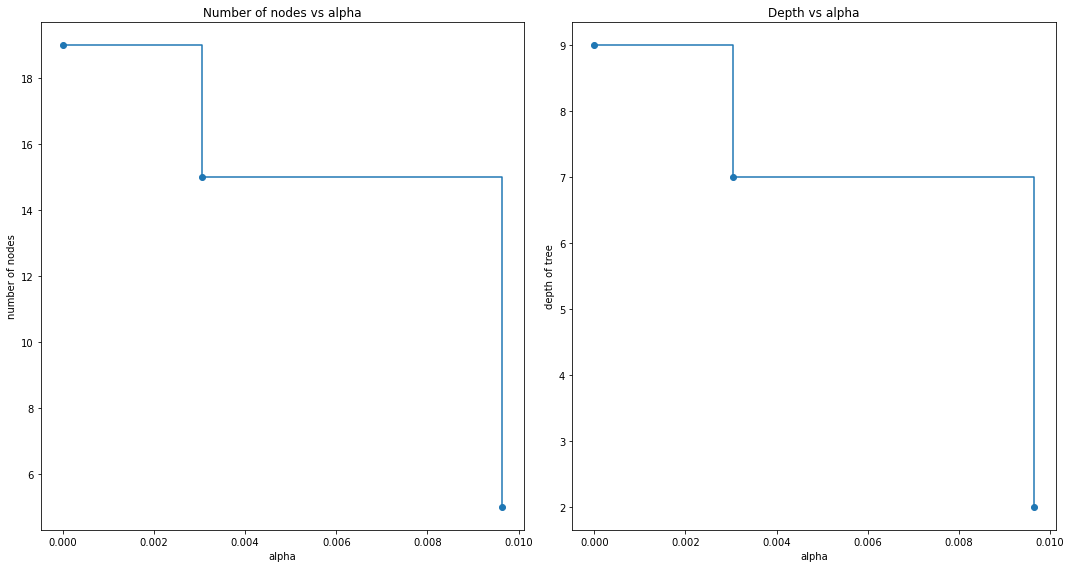

In [40]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,8)

ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

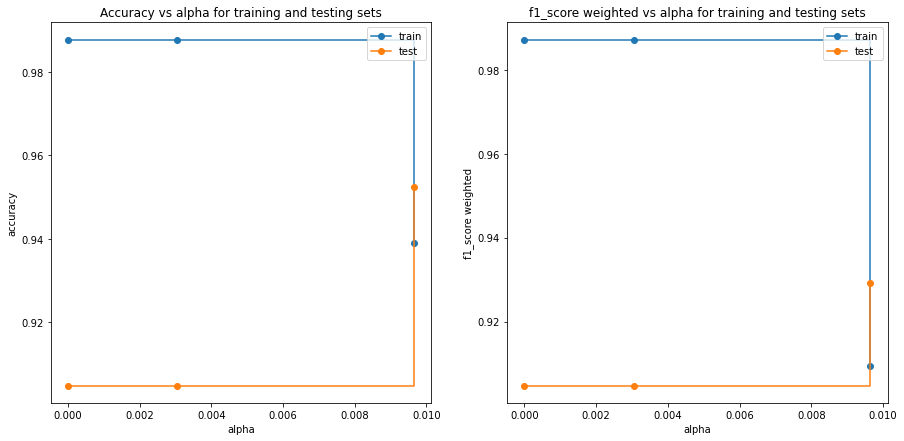

In [41]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_5vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_5vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)

ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_5vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_5vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()

[Text(334.8, 679.5, 'TIC type_C <= 0.5\ngini = 0.115\nsamples = 82\nvalue = [77, 5]\nclass = 0'),
 Text(167.4, 407.69999999999993, 'gini = 0.0\nsamples = 56\nvalue = [56, 0]\nclass = 0'),
 Text(502.20000000000005, 407.69999999999993, 'T2 <= 0.5\ngini = 0.311\nsamples = 26\nvalue = [21, 5]\nclass = 0'),
 Text(334.8, 135.89999999999998, 'gini = 0.496\nsamples = 11\nvalue = [6, 5]\nclass = 0'),
 Text(669.6, 135.89999999999998, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]\nclass = 0')]

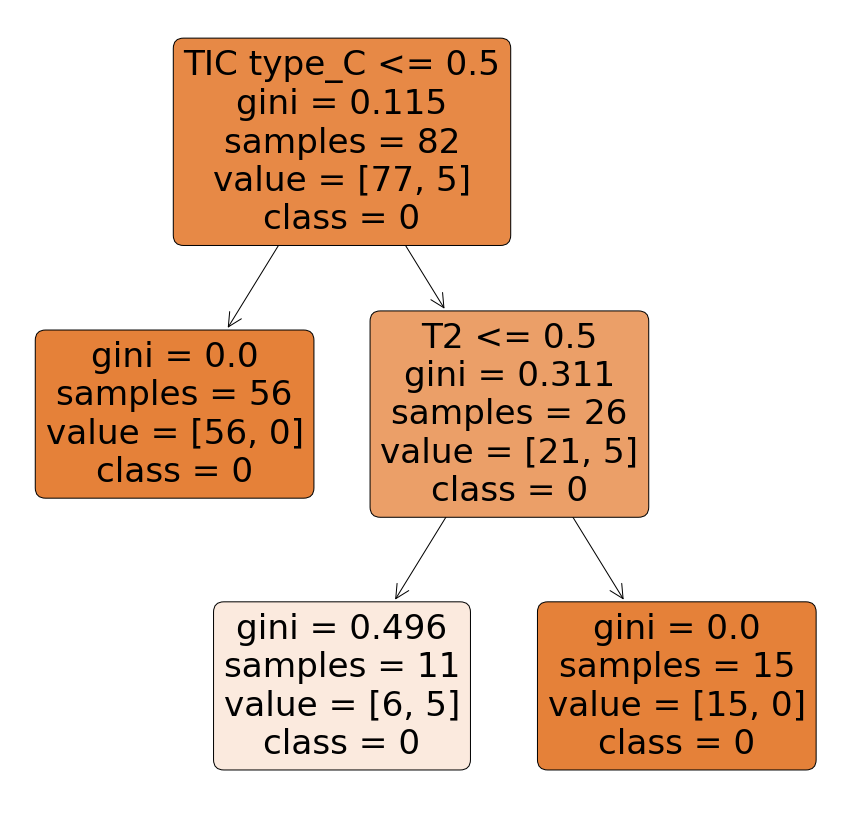

In [42]:
best_clf = clfs[2]
clf_5vsAll = best_clf
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

In [43]:
print(classification_report(y_test_5vsAll, clf_5vsAll.predict(X_test),zero_division = 0))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.00      0.00      0.00         1

    accuracy                           0.95        21
   macro avg       0.48      0.50      0.49        21
weighted avg       0.91      0.95      0.93        21



In [44]:
#ora faccio un merge di sti alberi in particolare e poi automatizzo il processo

## Partiamo dal merge dei 5 alberi one vs all (e magari vedo se fa meglio dell'altro classificatore a probabilità mergiate)

In [45]:
clfs = [clf_1vsAll, clf_2vsAll, clf_3vsAll, clf_4vsAll, clf_5vsAll]

outputs = np.zeros((len(clfs), len(X_test)))
prob_outputs = np.zeros((len(clfs), len(X_test)))

for n, clf in enumerate(clfs):
        outputs[n] = clf.predict(X_test)
        prob_outputs[n] = clf.predict_proba(X_test).T[1]
        
outputs = np.transpose(outputs)
prob_outputs = np.transpose(prob_outputs)

#predictions based on max probability

max_prob_predictions = [np.argmax(x)+1 for x in prob_outputs]

single_one_predictions = [np.argmax(x)+1 if sum(x) == 1 else None for x in outputs]

double_one_predictions = [[ label+1 for label,value in enumerate(x)
                           if value == 1]  if sum(x) in (1,2) else None for x in outputs]     


print('### RESULTS ###\n')
print('## Classification report for probabilities merge: ##\n')
print(classification_report(y_test, max_prob_predictions, zero_division = 0))
print('\n## Single one predictions: ##\n')
print('# Test set size: {}\n'.format(len(y_test)))
print('# Number of single ones: {}'.format(len([x for x in single_one_predictions if x])))
single_one_correct = sum([1 if x else 0 for x in single_one_predictions == y_test])
print('# Single ones correct predictions: {}\n\n'.format(single_one_correct))
print('# Number of at most two ones: {}'.format(len([x for x in double_one_predictions if x])))
double_one_correct = sum([1 if y in double_one_predictions else 0 for n,y in enumerate(y_test)])

print('# Doube ones correct predictions: {}\n'.format(double_one_correct))


### RESULTS ###

## Classification report for probabilities merge: ##

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       0.92      1.00      0.96        11
           4       1.00      1.00      1.00         6
           5       0.00      0.00      0.00         1

    accuracy                           0.95        21
   macro avg       0.78      0.80      0.79        21
weighted avg       0.91      0.95      0.93        21


## Single one predictions: ##

# Test set size: 21

# Number of single ones: 21
# Single ones correct predictions: 20


# Number of at most two ones: 21
# Doube ones correct predictions: 0



In [46]:


single_one_predictions


[4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 2, 1, 3, 3, 4, 4]

In [47]:
y_test

3     4
37    4
2     3
29    4
56    3
52    3
57    3
51    3
61    5
77    3
86    3
71    3
39    4
98    3
28    1
25    2
46    1
27    3
66    3
35    4
7     4
Name: COD ISTO, dtype: int64

In [48]:
#automatizzo il processo
def esperimento(X, y, balanced_trees = False, test_size = 0.25,  scoring_f = accuracy_score,
                random_state_tree = None, n_it = 10, smotenc_aug = False, print_trees = False):
    
    proba_scores = []
    trees = []
    
    for n in range(n_it):
        
        print('### ITERATION %d ###\n\n' %(n+1))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                            shuffle = True, stratify = y)
        
        print('## Dataset split completed ##')
        
        if smotenc_aug == True:
            
            smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=[0,2,3,4,5],
                          sampling_strategy = 'minority')
            
            for i in range(4):
                
                X_train, y_train = smt.fit_resample(X_train, y_train)
                
            print('## SMOTENC augmentation completed ##')
     
        #dizionari che contengono le labels binarie da utilizzare per allenare i DT one vs all
        bin_y_train = dict()
        bin_y_test = dict()
        
        for i in range(1,6):
            bin_y_train[i] = [1 if x == i else 0 for x in y_train ]
            bin_y_test[i] = [1 if x == i else 0 for x in y_test ]
        
        print('## Binary labels prepared ##')
        
        #dizionario per contenere le probabilità ottenute da ciascun DT one vs all nell'iterazione corrente
        predict_proba = dict()
        
        #induzione dei 5 DT one vs all
        current_trees = []
        for n_tree in range(1,6):
            
            print('# Tuning hyper-parameters DT one vs all n.%d #\n' %(n_tree))
            
            if balanced_trees == True:
                class_weight = 'balanced'
            else:
                class_weight = None
            
            clf = tree.DecisionTreeClassifier(random_state = random_state_tree, class_weight = class_weight)
        
            ccp_alphas = clf.cost_complexity_pruning_path(X_train, bin_y_train[n_tree]).ccp_alphas

            clfs = []
            for ccp_alpha in ccp_alphas:
                clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha,
                                                  class_weight = class_weight)
                clf.fit(X_train, bin_y_train[n_tree])
                clfs.append(clf)
            
            if scoring_f is f1_score:
                train_scores= [scoring_f(bin_y_train[n_tree],
                                         clf.predict(X_train), average = 'weighted') for clf in clfs]
                test_scores=[scoring_f(bin_y_test[n_tree], clf.predict(X_test), average = 'weighted') for clf in clfs]
            else:
                train_scores= [scoring_f(bin_y_train[n_tree], clf.predict(X_train)) for clf in clfs]
                test_scores=[scoring_f(bin_y_test[n_tree], clf.predict(X_test)) for clf in clfs]
                
            clfs.reverse()
            test_scores.reverse()
            
            best_clf_index = np.argmax(test_scores)
            best_clf = clfs[best_clf_index]
            
                
            
            print("Parameters set found:\n")
            print(best_clf.get_params())
            print()
            
            print(" Score of the estimator on test set: %0.3f\n" %(test_scores[best_clf_index]))
            current_trees.append(best_clf)
            predict_proba[n_tree] = best_clf.predict_proba(X_test)[:,1]
            print('-'*100)
        
        trees.append(current_trees)

        print('# Probabilities aggregation #\n')
        
        array = np.array( [predict_proba[1],  predict_proba[2],  predict_proba[3],  
                           predict_proba[4], predict_proba[5]])
        array = np.transpose(array)
        y_pred_proba = np.argmax(array, axis = 1)+1
        
        print('Final classifier performance:')
        print(classification_report( y_test, y_pred_proba, zero_division = 0))
        if scoring_f is f1_score:
            proba_score = f1_score(y_test, y_pred_proba, average = 'weighted')
        else:
            proba_score = scoring_f(y_test, y_pred_proba)
        proba_scores.append(proba_score)
        
    print('\n\n### Mean final score: %0.3f , Std dev: %0.3f ###' %( np.mean(proba_scores), np.std(proba_scores)))
    
    if print_trees :
        print('\n\n### Best trees based on selected scoring function: ###')
        best_iteration = np.argmax(proba_scores)
        print('Referred iteration: {}'.format(best_iteration+1))
        best_trees = trees[best_iteration]
        
        fig, ax = plt.subplots(5,1)
        fig.set_size_inches(25, 15)
        
        for n,t in enumerate(best_trees):
            print('Tree {} vs all'.format(n+1))
            print(t.get_params())
            tree.plot_tree(t,
               feature_names = X.columns,
               class_names = ['0','1'], filled = True, rounded = True, ax = ax[n])
       

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.04245445584316014, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_st

## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.03736560693641621, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimat

Parameters set found:

{'ccp_alpha': 0.13430287149252096, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.923

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         1
           3       1.00      0.62      0.76        13
           4       1.00      1.00      1.00         7
           5       0.25      1.00      0.40         2

    accuracy                           0.77        26
   macro avg       0.85      0.86      0.79        26
weighted avg   

Parameters set found:

{'ccp_alpha': 0.0456327985739751, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.923

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

-------------------------------------------------------------------------------------------

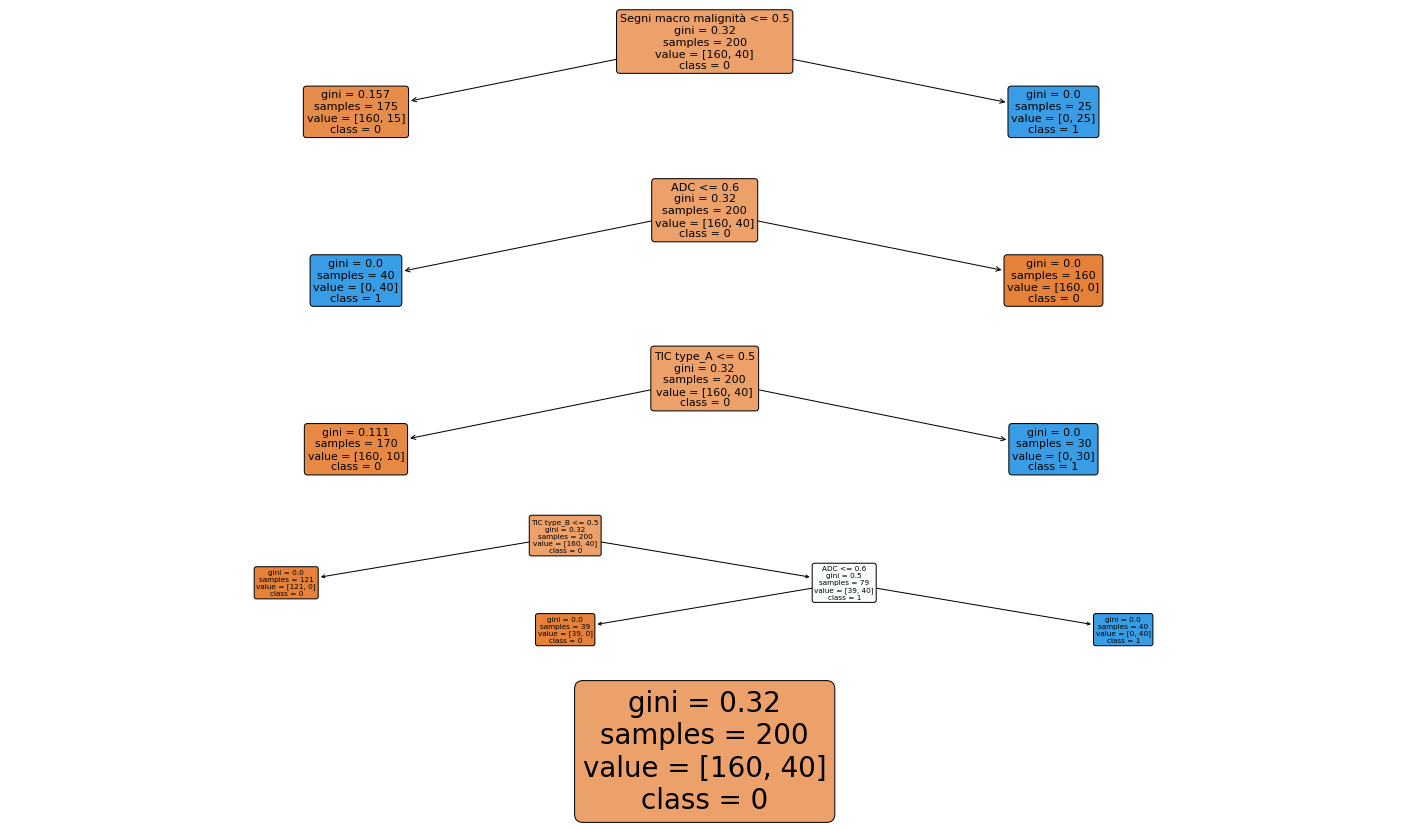

In [49]:
#alberi non bilanciati, accuratezza, sì smotenc

esperimento(X, y, smotenc_aug = True, print_trees = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.04633478682170541, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_st

Parameters set found:

{'ccp_alpha': 0.007579916758773141, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.962

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         1
           3       0.92      0.92      0.92        13
           4       1.00      1.00      1.00         7
           5       0.67      1.00      0.80         2

    accuracy                           0.92        26
   macro avg       0.92      0.92      0.90        26
weighted avg  

Parameters set found:

{'ccp_alpha': 0.02156893459138043, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.962

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

------------------------------------------------------------------------------------------

## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.0032666666666666677, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estim

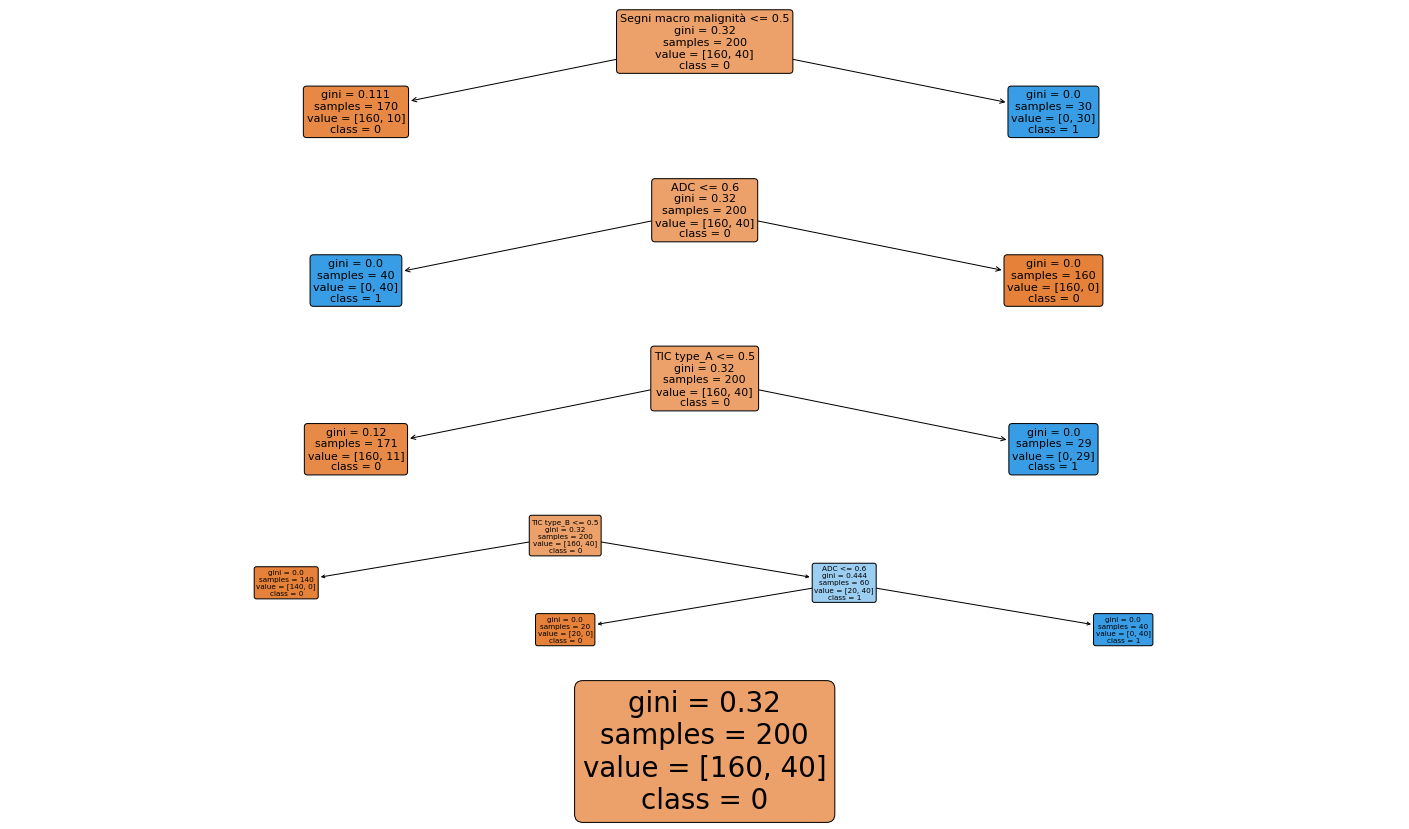

In [50]:
#alberi non bilanciati, accuratezza, sì smotenc

esperimento(X, y, smotenc_aug = True, print_trees = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.3100621118012422, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.830

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_sta

Parameters set found:

{'ccp_alpha': 0.0076818181818181855, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.905

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       1.00      0.85      0.92        13
           4       1.00      1.00      1.00         7
           5       0.50      1.00      0.67         2

    accuracy                           0.92        26
   macro avg       0.90      0.97      0.92        26
weighted avg 

Parameters set found:

{'ccp_alpha': 0.006666666666666666, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.961

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.4 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

-----------------------------------------------------------------------------------------

## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.0339770053475936, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimato

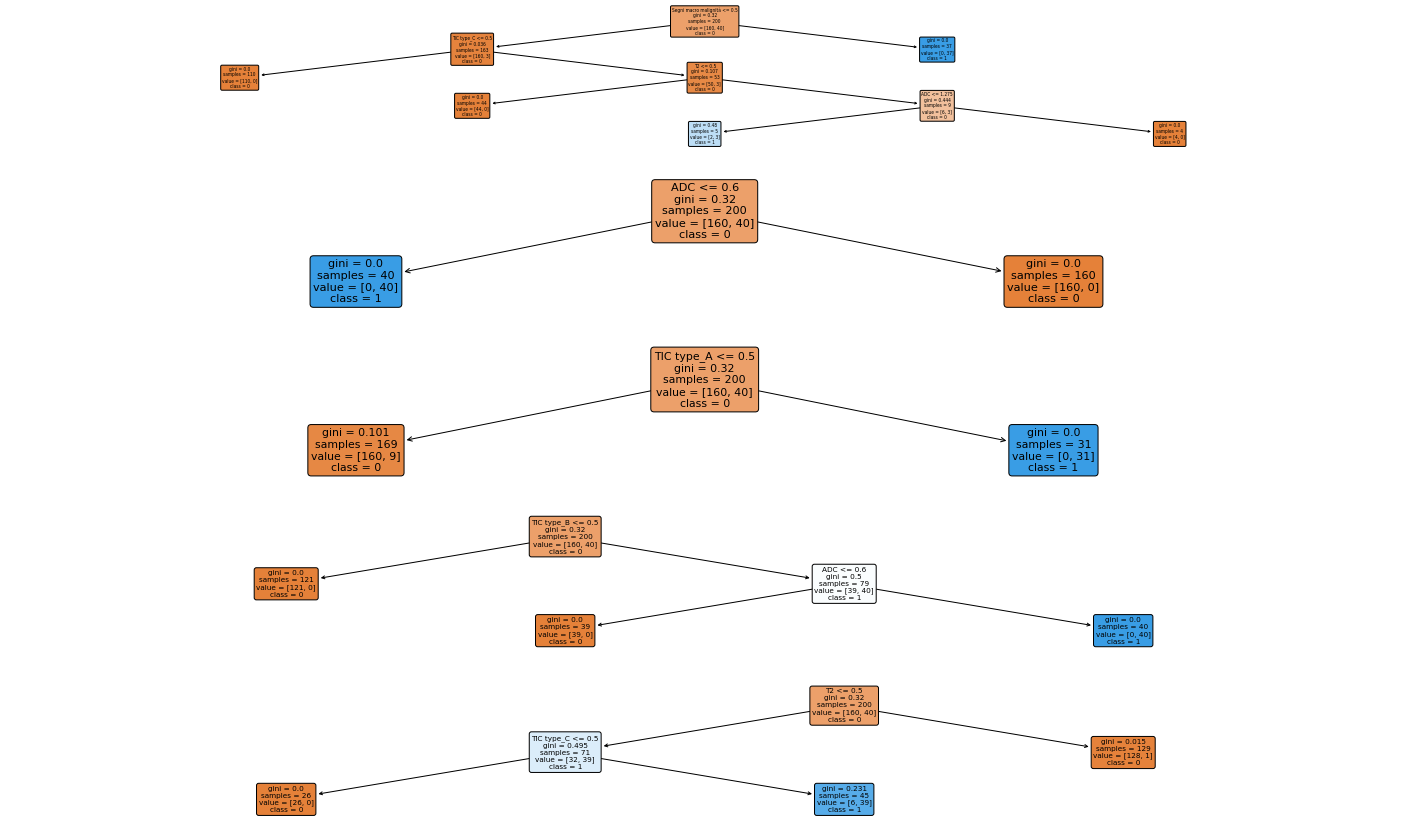

In [51]:
#alberi non bilanciati, f1_score, sì smotenc

esperimento(X, y, smotenc_aug = True, print_trees = True, scoring_f = f1_score)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.030631175640250047, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_s

Parameters set found:

{'ccp_alpha': 0.06841079460269864, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.965

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       1.00      1.00      1.00         1
           3       0.80      0.92      0.86        13
           4       1.00      1.00      1.00         7
           5       0.00      0.00      0.00         2

    accuracy                           0.85        26
   macro avg       0.69      0.72      0.70        26
weighted avg   

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'ccp_alpha': 0.0456327985739751, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.923

-------------------------------------------------------------------------------------------

## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.019218441814595668, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estima

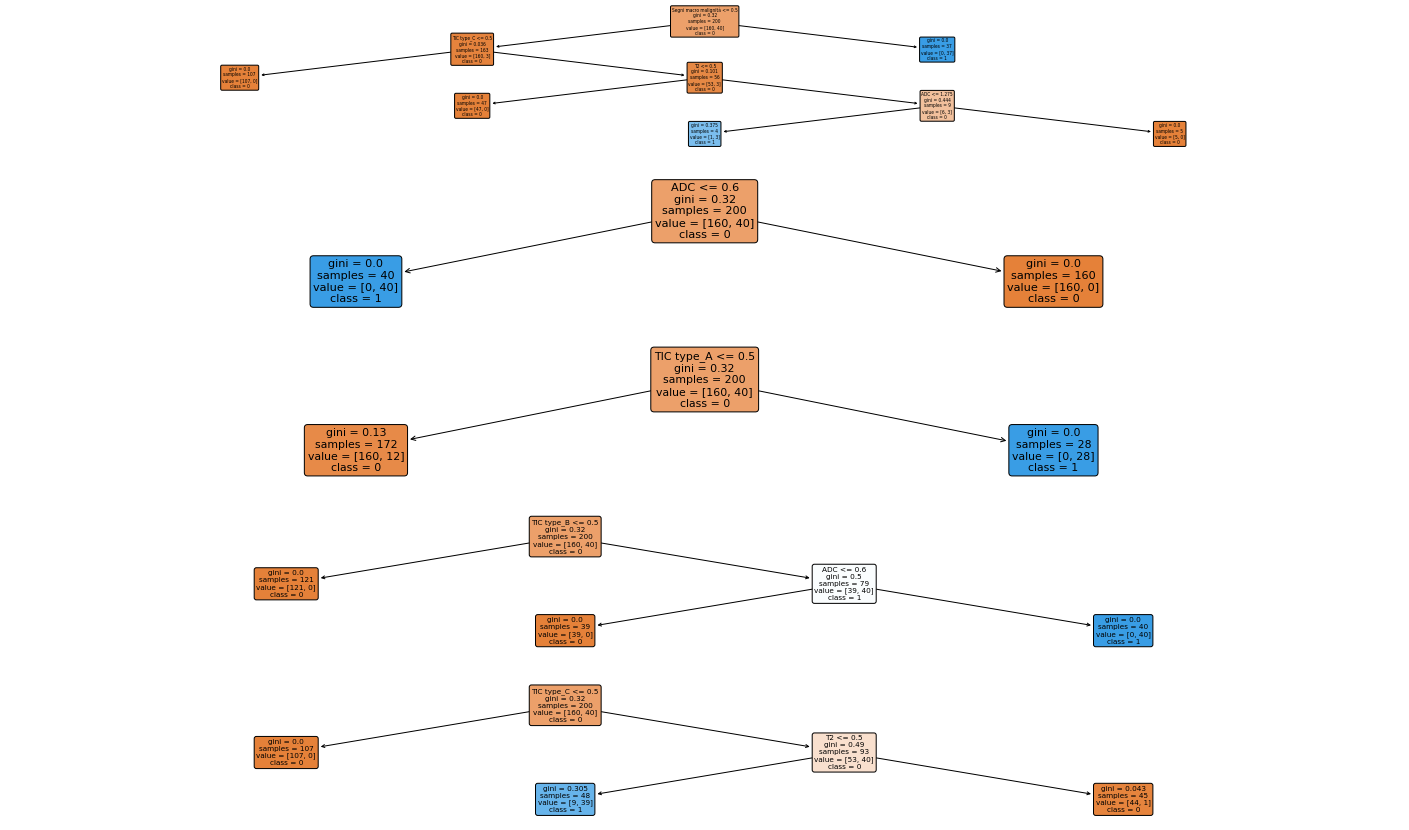

In [52]:
#alberi non bilanciati, f1_score, sì smotenc

esperimento(X, y, smotenc_aug = True, print_trees = True, scoring_f = f1_score)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Binary labels prepared ##
# Tuning hyper-parameters DT one vs all n.1 #

Parameters set found:

{'ccp_alpha': 0.004444444444444443, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.2 #

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.

Parameters set found:

{'ccp_alpha': 0.26923076923076916, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.886

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       0.92      0.85      0.88        13
           4       1.00      1.00      1.00         7
           5       0.33      0.50      0.40         2

    accuracy                           0.88        26
   macro avg       0.85      0.87      0.86        26
weighted 

Parameters set found:

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 1.000

----------------------------------------------------------------------------------------------------
# Tuning hyper-parameters DT one vs all n.3 #

Parameters set found:

{'ccp_alpha': 0.05490196078431375, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.842

------------------------------------------------------------------------------

Parameters set found:

{'ccp_alpha': 0.2373271889400922, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}

 Score of the estimator on test set: 0.886

----------------------------------------------------------------------------------------------------
# Probabilities aggregation #

Final classifier performance:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         1
           3       0.90      0.69      0.78        13
           4       1.00      1.00      1.00         7
           5       0.20      0.50      0.29         2

    accuracy                           0.81        26
   macro avg       0.82      0.84      0.81        26
weighted a

Tree 2 vs all
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 3 vs all
{'ccp_alpha': 0.02871094849423024, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Tree 4 vs all
{'ccp_alpha': 0.19597989949748748, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': '

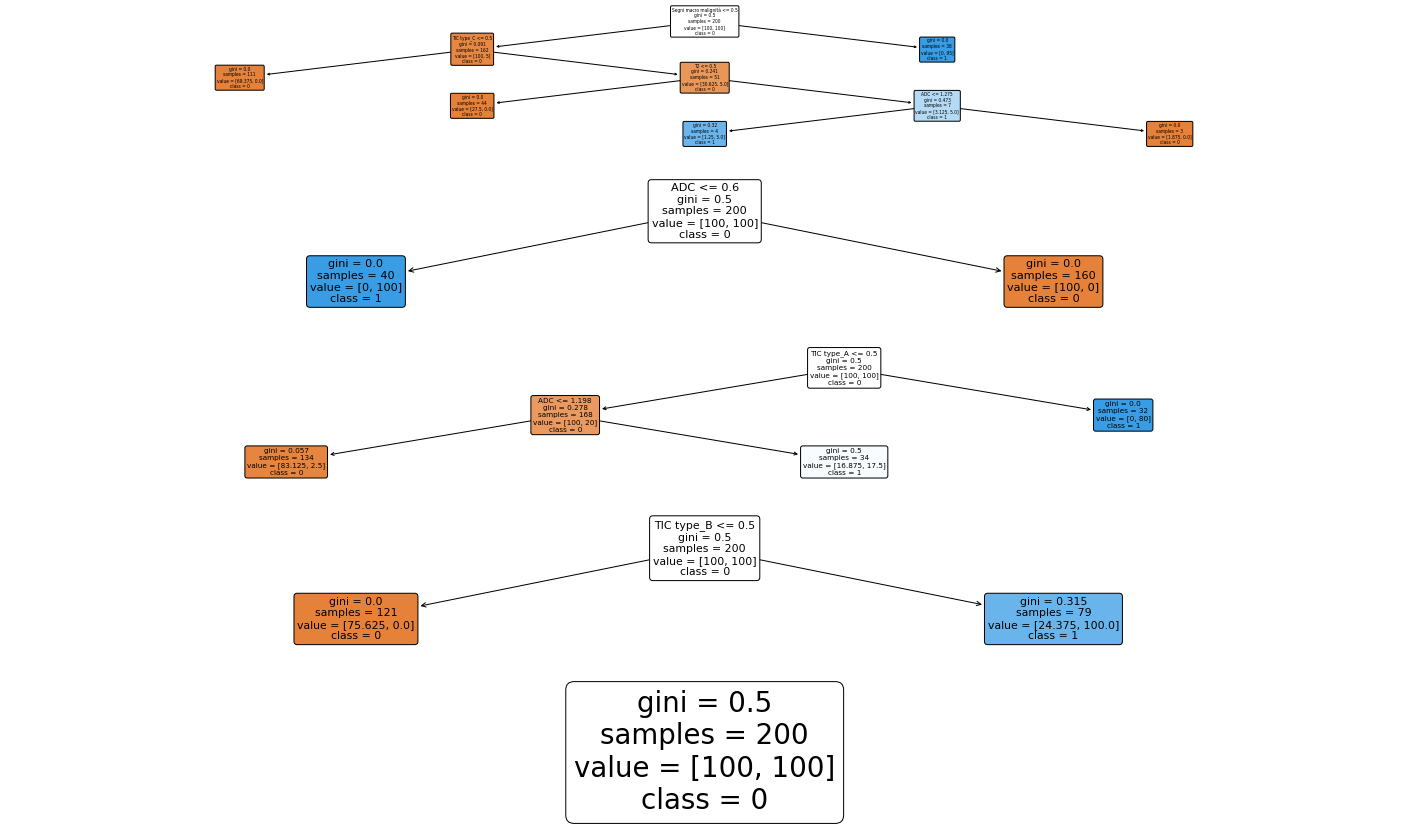

In [53]:
#alberi non bilanciati, f1_score, sì smotenc

esperimento(X, y, smotenc_aug = True, print_trees = True, scoring_f = f1_score, balanced_trees = True)